In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.manifold import TSNE
import matplotlib.cm as cm
import tensorflow.keras.backend as K

In [9]:
# Set seed
Seed = 40
np.random.seed(Seed)

# Load data
data_dir = 'Data/SARS-CoV-2-CT-Scan'
disease_types = ['COVID', 'non-COVID']
train_data = []
for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])
train = pd.DataFrame(train_data, columns=['File', 'ID', 'Disease Type'])
train = train.sample(frac=1, replace=False, random_state=Seed).reset_index(drop=True)

IMAGE_SIZE = 224
channels = 3

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_train = X_train / 255.0
Y_train = to_categorical(train['ID'].values, num_classes=2)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=Seed)

62/62 [==============================] - 304s 5s/step


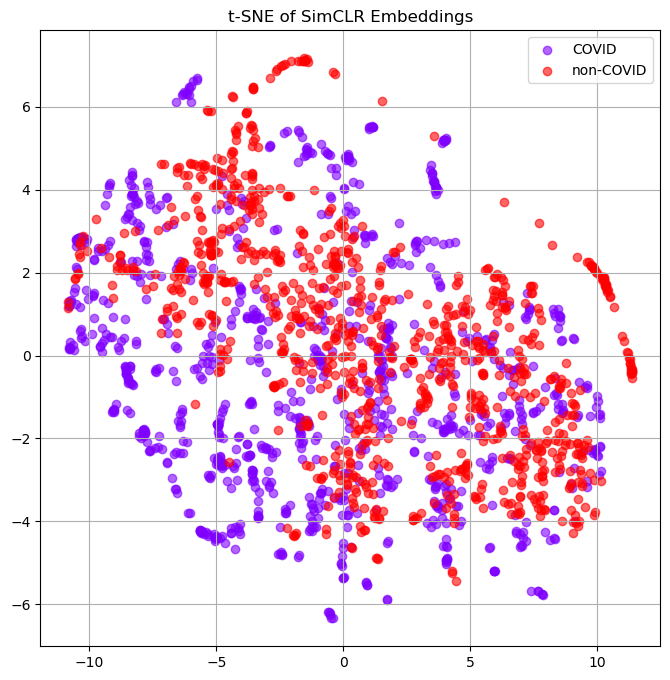

In [10]:
# SimCLR Encoder
base_model = DenseNet169(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='avg')
x = Dense(128, activation='relu')(base_model.output)
simclr_encoder = Model(inputs=base_model.input, outputs=x)
simclr_embeddings = simclr_encoder.predict(X_train)

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_embedded = tsne.fit_transform(simclr_embeddings)
labels = np.argmax(Y_train, axis=1)
plt.figure(figsize=(8, 8))
colors = cm.rainbow(np.linspace(0, 1, 2))
for i, c in zip(range(2), colors):
    plt.scatter(X_embedded[labels == i, 0], X_embedded[labels == i, 1], color=c, label=disease_types[i], alpha=0.6)
plt.legend()
plt.title("t-SNE of SimCLR Embeddings")
plt.grid(True)
plt.show()

In [11]:
# DenseNet169 Classification
def build_densenet169(IMAGE_SIZE, channels):
    densenet169 = DenseNet169(weights='imagenet', include_top=False)
    input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, channels))
    x = Conv2D(3, (3, 3), padding='same')(input)
    x = densenet169(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(input, output)
    initial_learning_rate = 0.003
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96,
        staircase=True)

    optimizer = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model1 = build_densenet169(IMAGE_SIZE, channels)
model2 = build_densenet169(IMAGE_SIZE, channels)
model3 = build_densenet169(IMAGE_SIZE, channels)

In [12]:
# Data augmentation
datagen = ImageDataGenerator(rotation_range=360, width_shift_range=0.2, height_shift_range=0.2,
                             zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
datagen.fit(X_train)

models = [model1, model2, model3]
history_list = []
for i, model in enumerate(models):
    print(f"\nTraining Model {i + 1}")
    hist = model.fit(datagen.flow(X_train, Y_train, batch_size=32),
                     steps_per_epoch=X_train.shape[0] // 32,
                     epochs=75,
                     verbose=1)
    history_list.append(hist)


Training Model 1
Epoch 1/75
62/62 [==============================] - 1458s 23s/step - loss: 0.5642 - accuracy: 0.7480
Epoch 2/75
62/62 [==============================] - 1423s 23s/step - loss: 0.3596 - accuracy: 0.8488
Epoch 3/75
62/62 [==============================] - 1420s 23s/step - loss: 0.3205 - accuracy: 0.8710
Epoch 4/75
62/62 [==============================] - 1420s 23s/step - loss: 0.2753 - accuracy: 0.8896
Epoch 5/75
62/62 [==============================] - 1423s 23s/step - loss: 0.2449 - accuracy: 0.8987
Epoch 6/75
62/62 [==============================] - 1422s 23s/step - loss: 0.2289 - accuracy: 0.9057
Epoch 7/75
62/62 [==============================] - 1421s 23s/step - loss: 0.1918 - accuracy: 0.9239
Epoch 8/75
62/62 [==============================] - 1419s 23s/step - loss: 0.1679 - accuracy: 0.9345
Epoch 9/75
62/62 [==============================] - 1422s 23s/step - loss: 0.1497 - accuracy: 0.9385
Epoch 10/75
62/62 [==============================] - 1423s 23s/step - los

62/62 [==============================] - 1493s 24s/step - loss: 0.1963 - accuracy: 0.9173
Epoch 7/75
62/62 [==============================] - 1494s 24s/step - loss: 0.2035 - accuracy: 0.9183
Epoch 8/75
62/62 [==============================] - 1488s 24s/step - loss: 0.1694 - accuracy: 0.9259
Epoch 9/75
62/62 [==============================] - 1491s 24s/step - loss: 0.1491 - accuracy: 0.9355
Epoch 10/75
62/62 [==============================] - 1493s 24s/step - loss: 0.1372 - accuracy: 0.9435
Epoch 11/75
62/62 [==============================] - 1490s 24s/step - loss: 0.1230 - accuracy: 0.9511
Epoch 12/75
62/62 [==============================] - 1490s 24s/step - loss: 0.1056 - accuracy: 0.9582
Epoch 13/75
62/62 [==============================] - 1491s 24s/step - loss: 0.1133 - accuracy: 0.9556
Epoch 14/75
62/62 [==============================] - 1492s 24s/step - loss: 0.1193 - accuracy: 0.9561
Epoch 15/75
62/62 [==============================] - 1491s 24s/step - loss: 0.0921 - accuracy: 0.

62/62 [==============================] - 1497s 24s/step - loss: 0.1238 - accuracy: 0.9526
Epoch 12/75
62/62 [==============================] - 1498s 24s/step - loss: 0.1080 - accuracy: 0.9662
Epoch 13/75
62/62 [==============================] - 1493s 24s/step - loss: 0.1175 - accuracy: 0.9556
Epoch 14/75
62/62 [==============================] - 1497s 24s/step - loss: 0.0878 - accuracy: 0.9642
Epoch 15/75
62/62 [==============================] - 1494s 24s/step - loss: 0.0948 - accuracy: 0.9617
Epoch 16/75
62/62 [==============================] - 1497s 24s/step - loss: 0.0857 - accuracy: 0.9667
Epoch 17/75
62/62 [==============================] - 1501s 24s/step - loss: 0.0910 - accuracy: 0.9652
Epoch 18/75
62/62 [==============================] - 1502s 24s/step - loss: 0.0530 - accuracy: 0.9824
Epoch 19/75
62/62 [==============================] - 1503s 24s/step - loss: 0.0752 - accuracy: 0.9748
Epoch 20/75
62/62 [==============================] - 1502s 24s/step - loss: 0.0436 - accuracy:


Evaluating Model 1
16/16 [==============================] - 84s 5s/step
Classification Report:
              precision    recall  f1-score   support

       COVID       0.88      0.99      0.93       242
   non-COVID       0.99      0.87      0.92       255

    accuracy                           0.93       497
   macro avg       0.93      0.93      0.93       497
weighted avg       0.93      0.93      0.93       497



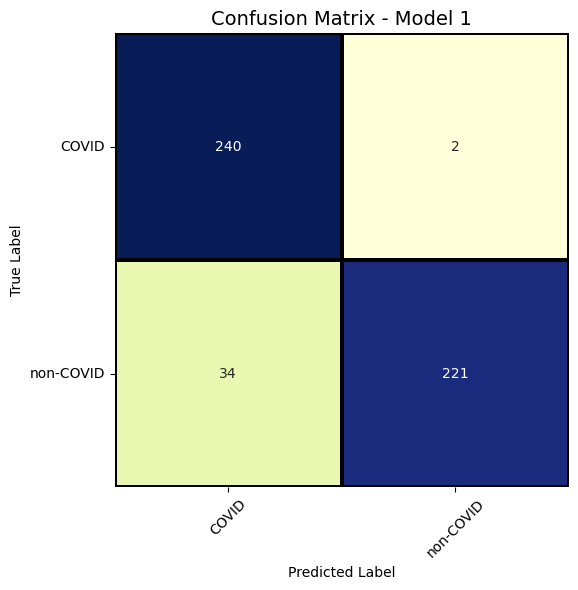


Evaluating Model 2
16/16 [==============================] - 85s 5s/step
Classification Report:
              precision    recall  f1-score   support

       COVID       0.99      0.98      0.99       242
   non-COVID       0.98      0.99      0.99       255

    accuracy                           0.99       497
   macro avg       0.99      0.99      0.99       497
weighted avg       0.99      0.99      0.99       497



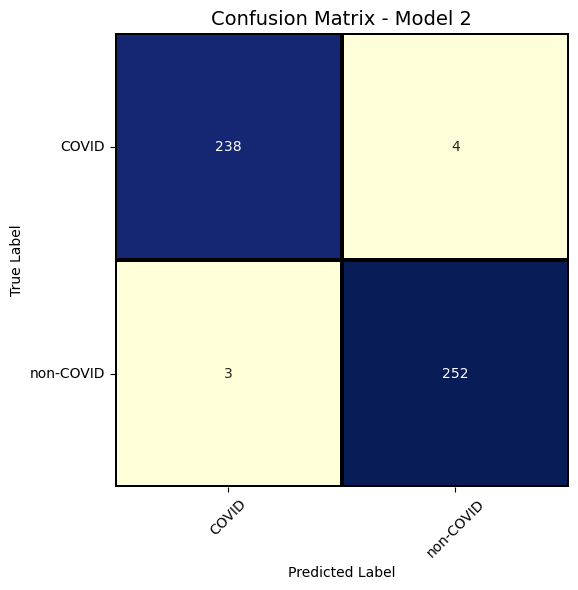


Evaluating Model 3
16/16 [==============================] - 84s 5s/step
Classification Report:
              precision    recall  f1-score   support

       COVID       0.61      1.00      0.76       242
   non-COVID       1.00      0.40      0.57       255

    accuracy                           0.69       497
   macro avg       0.81      0.70      0.66       497
weighted avg       0.81      0.69      0.66       497



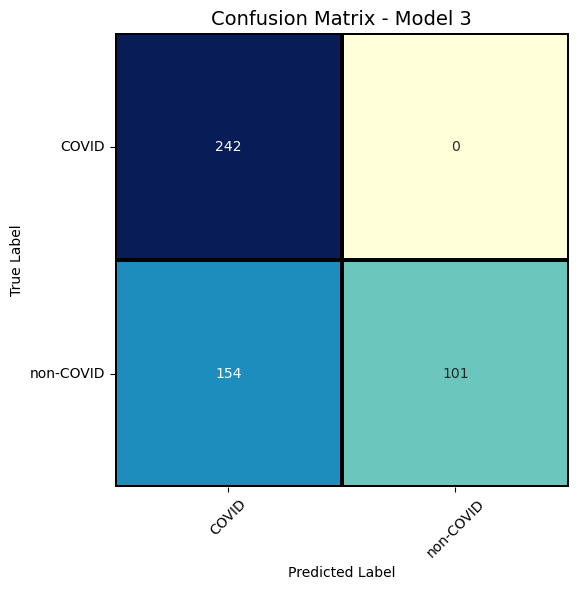

In [13]:
# Evaluation
for i, model in enumerate(models):
    print(f"\nEvaluating Model {i + 1}")
    Y_pred = model.predict(X_val)
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    Y_true = np.argmax(Y_val, axis=1)

    print("Classification Report:")
    print(classification_report(Y_true, Y_pred_classes, target_names=disease_types))

    cm = confusion_matrix(Y_true, Y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', linewidths=1.5, linecolor='black',
                xticklabels=disease_types, yticklabels=disease_types, square=True, cbar=False)
    plt.title(f'Confusion Matrix - Model {i + 1}', fontsize=14)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


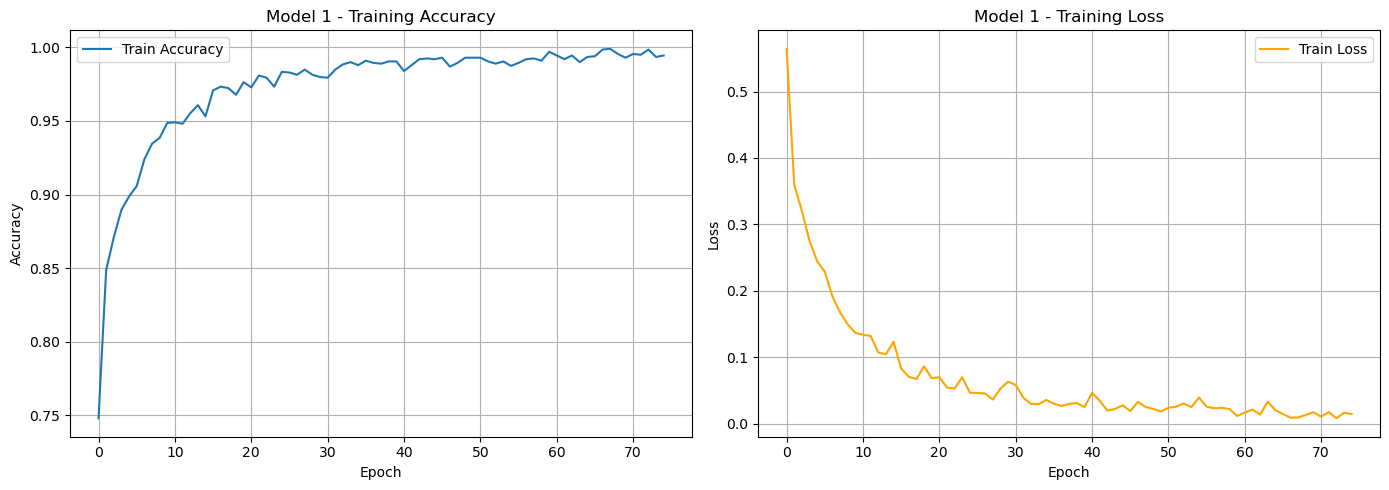

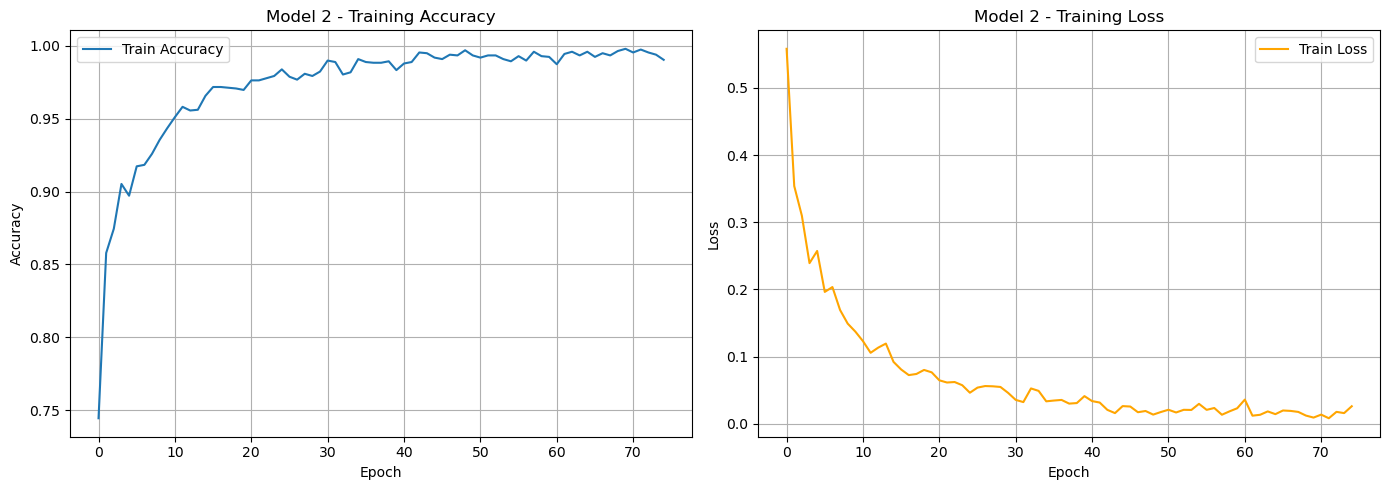

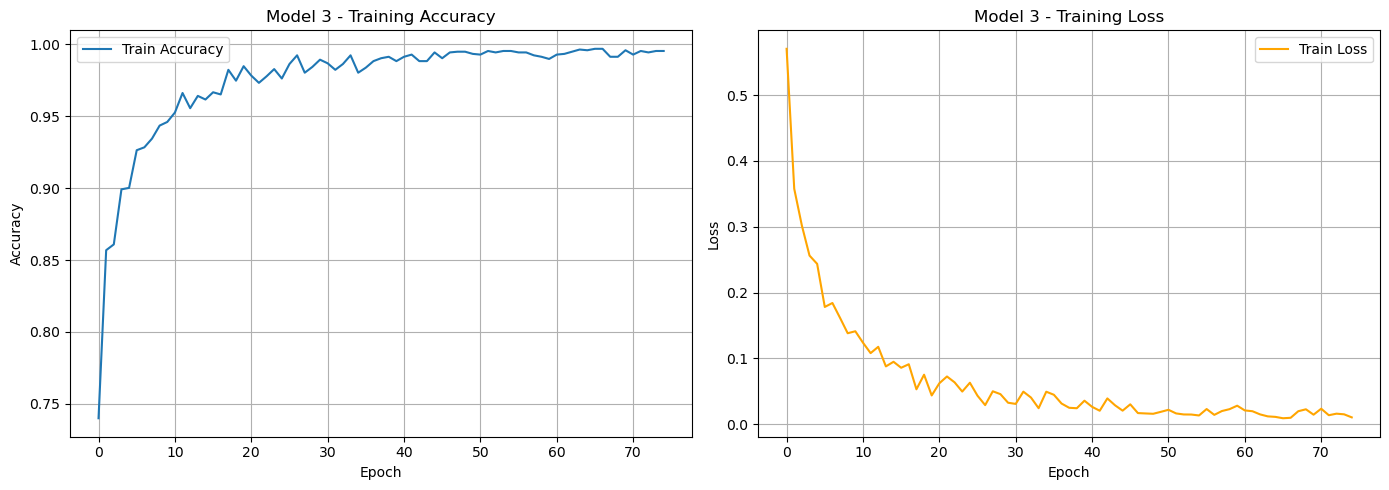

In [14]:
# Loss & Accuracy Plots
for i, history in enumerate(history_list):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.title(f'Model {i+1} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='orange')
    plt.title(f'Model {i+1} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [15]:
# Grad-CAM++
def grad_cam_plus_plus(model, image, cls, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_outputs, predictions = grad_model(np.array([image]))
                loss = predictions[:, cls]
            grads = tape3.gradient(loss, conv_outputs)
        grads2 = tape2.gradient(grads, conv_outputs)
    grads3 = tape1.gradient(grads2, conv_outputs)

    numerator = grads ** 2
    denominator = 2 * grads ** 2 + conv_outputs * grads3
    denominator = np.where(denominator != 0.0, denominator, 1e-10)
    weights = np.maximum(numerator / denominator, 0.0)
    weights = np.sum(weights, axis=(1, 2))

    cam = np.zeros(conv_outputs[0].shape[:2], dtype=np.float32)
    for i, w in enumerate(weights[0]):
        cam += w * conv_outputs[0][:, :, i]
    cam = np.maximum(cam, 0)
    cam = cam / (np.max(cam) + 1e-8)
    return cam

layer_name = 'conv5_block32_concat'
sample_indices = [np.where(np.argmax(Y_val, axis=1)==i)[0][0] for i in range(2)]
for i, idx in enumerate(sample_indices):
    sample_img = X_val[idx]
    sample_label = np.argmax(Y_val[idx])
    pred = np.argmax(models[0].predict(np.expand_dims(sample_img, axis=0))[0])
    cam = grad_cam_plus_plus(models[0], sample_img, pred, layer_name)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.uint8(sample_img * 255), 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6, 6))
    plt.title(f"Grad-CAM++ - True: {disease_types[sample_label]} / Predicted: {disease_types[pred]}")
    plt.axis('off')
    plt.imshow(overlay[..., ::-1])
    plt.show()


1/1 [==============================] - 0s 391ms/step


ValueError: No such layer: conv5_block32_concat. Existing layers are: ['input_3', 'conv2d', 'densenet169', 'global_average_pooling2d', 'batch_normalization', 'dense_1', 'batch_normalization_1', 'dense_2'].